# Demonstration of Multi-Arm Bandit using the Agent Framework

In [1]:
import nxsdk.api.n2a as nx
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from banditAgent import Bandit
from utils import *

First we will start off by selecting the true parameters of reward for each arm following a Bernoulli distribution (rewards of 1 or 0, with the parameter being probability of a 1).

In [3]:
#seed RNG for consistency
rs = RandomState(378902)

In [4]:
n_actions = 5
epsilon = 0.10

In [5]:
probabilities = get_rewards(rs, n_actions, 50, 60, 10)
optimal_arm = np.argmax(probabilities)

In [6]:
plotargs = {"figsize": (8,6), "dpi" : 100}

Text(0,0.5,'Probability of Reward')

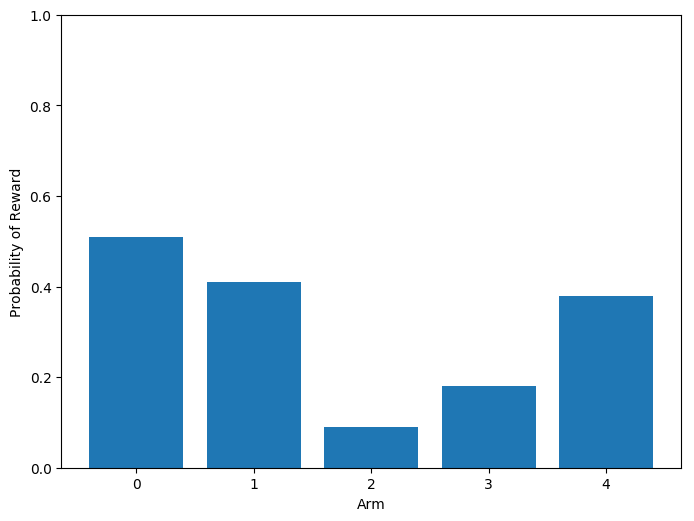

In [7]:
plt.figure(**plotargs)
plt.bar(np.arange(0,n_actions), probabilities)
plt.ylim(0,1)
plt.xlabel("Arm")
plt.ylabel("Probability of Reward")

Now, we set the parameters for the spiking agent. It will sample for 2000 epochs, with a period of 128 cycles for each to estimate the best arm

In [8]:
l_epoch = 128
episodes = 2000
runs = 1

In [9]:
#create the bandit using these settings
bandit = Bandit(probabilities, l_epoch = l_epoch, n_replicates = 2, n_epochs = episodes)

In [10]:
#set a probe to record the spikes from its continuous estimations of value
ctx_spks = bandit.cortex.get_outputs().probe(nx.ProbeParameter.SPIKE)

In [11]:
#run the bandit and disconnect once done
results = []
for i in range(runs):
    results.append(bandit.run())
bandit.board.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:34419
INFO:DRV:      Host server up..............Done 0.30s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996912.0432558
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996912.0432558/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996912.0432558/initnetwork_0_0.c.o -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/

In [12]:
actions, rewards, estimates = results[0]

We can look at the actions the agent takes and see that it converges onto the optimal arm with some occasional oscillations away as it continues to sample.

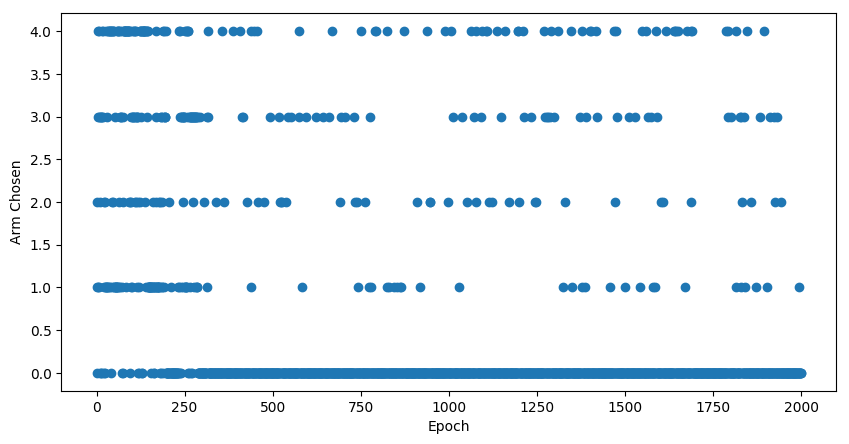

In [13]:
plot_choices(actions, probabilities, figsize=(10,5), dpi=100)

Average reward increases over time as it almost always samples the highest and second-highest arms.

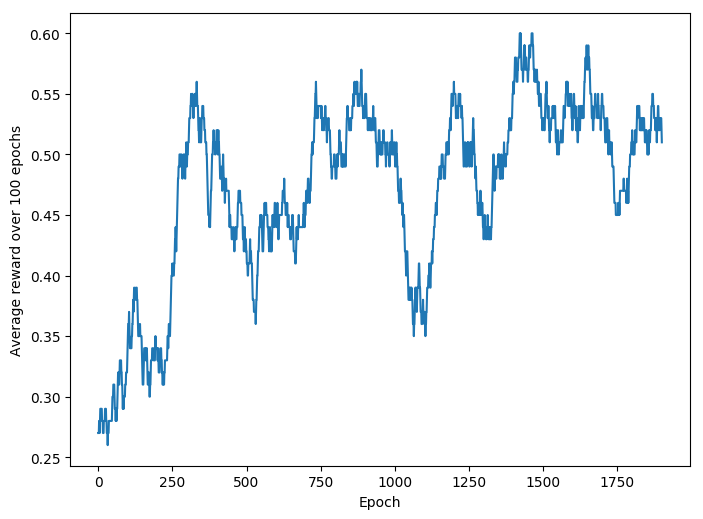

In [14]:
plot_avg_reward(rewards, **plotargs)

Directly looking at the spike counters which estimate the value of each arm, we can observe the relationship between high firing at the encoder output and the corresponding action being chosen. 

Text(0.5,1,'Estimate of value for each a over time')

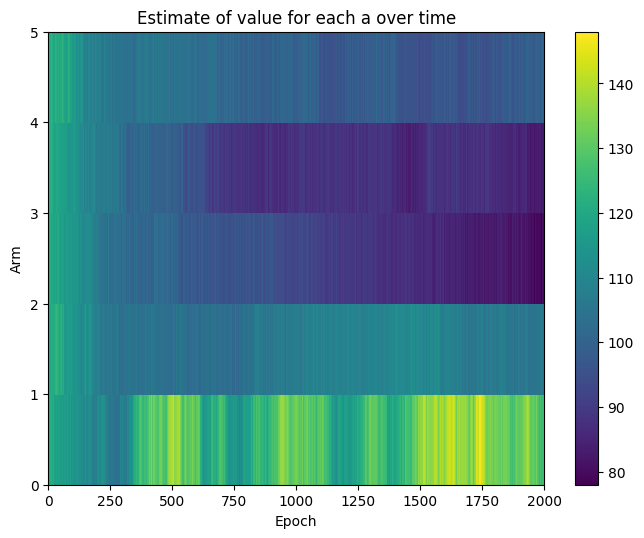

In [15]:
plt.figure(**plotargs)
plt.pcolor(estimates.transpose())
plt.colorbar()
plt.xlabel("Epoch")
plt.ylabel("Arm")
plt.title("Estimate of value for each a over time")

In this case, the encoder is counting spikes from multiple sources in the cortex; above, we define n_replicates in the bandit as 2, and this means 2 tracker nodes are being used for each state to provide a quicker estimate of value each epoch.

In [16]:
unwrap = lambda x: x[0].data

Text(0.5,1,'MFR of All Estimate Neurons over Time')

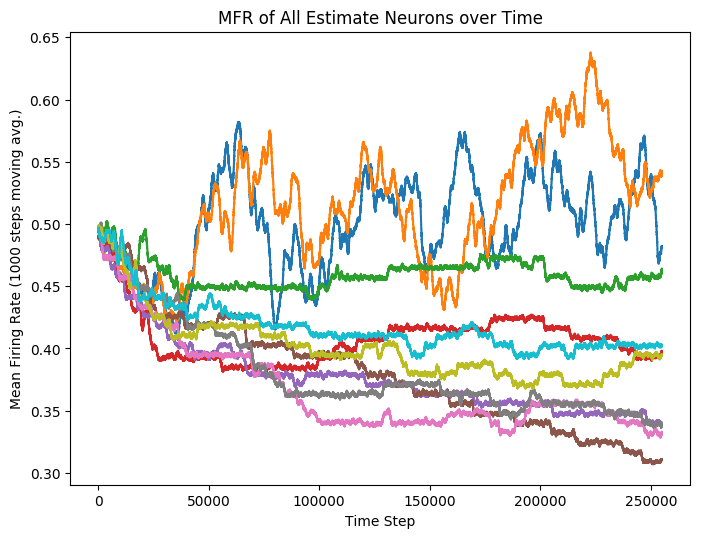

In [17]:
plt.figure(**plotargs)
for i in range(10):
    plt.plot(np.convolve(unwrap(ctx_spks)[i,:], np.ones(1000), mode='valid')/1000)
    
plt.xlabel("Time Step")
plt.ylabel("Mean Firing Rate (1000 steps moving avg.)")
plt.title("MFR of All Estimate Neurons over Time")

The two lines in blue and orange above indicate that the two trackers for the highest arm increase their firing rate as they are sampled and found to be above the rest. 

In [18]:
l_epochs = np.linspace(4, 128, 20).astype(np.int)

In [19]:
rc_performance = test_rate_coding(probabilities, l_epochs, trials=5, episodes=6400)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:42693
INFO:DRV:      Host server up..............Done 0.33s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996954.6562662
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996954.6562662/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996954.6562662/initnetwork_0_0.c.o -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/

INFO:DRV:      Compiling Embedded snips....Done 1.14s
INFO:DRV:      Compiling MPDS Registers....Done 0.82ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996959.1079311/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 4.34ms
INFO:DRV:      Transferring probes.........Done 6.11ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 2.86ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.23s
INFO:DRV:      Processing timeseries.......Done 2.85ms
INFO:DRV:  Executor: 25600 timeste

INFO:DRV:      Processing timeseries.......Done 1.15ms
INFO:DRV:  Executor: 25600 timesteps.......Done 0.29s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:37099
INFO:DRV:      Host server up..............Done 0.29s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996967.915547
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996967.915547/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/

INFO:DRV:      Compiling Embedded snips....Done 0.71s
INFO:DRV:      Compiling MPDS Registers....Done 0.84ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996972.1966958/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 3.23ms
INFO:DRV:      Transferring probes.........Done 8.36ms
INFO:DRV:      Configuring registers.......Done 0.04s
INFO:DRV:      Transferring spikes.........Done 0.81ms
INFO:HST:  chip=0 cpu=0 Setting up...    Executing... 
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.22s
INFO:DRV:      Processing timeseries.......Done 0.84ms
INFO:DRV:  Execut

INFO:DRV:      Processing timeseries.......Done 0.90ms
INFO:DRV:  Executor: 64000 timesteps.......Done 0.34s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:45741
INFO:DRV:      Host server up..............Done 0.26s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996980.4555576
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996980.4555576/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.79s
INFO:DRV:      Compiling MPDS Registers....Done 1.24ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996984.910014/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.28ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 8.66ms
INFO:DRV:      Configuring registers.......Done 0.01s
INFO:DRV:      Transferring spikes.........Done 2.52ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.30s
INFO:DRV:      Processing timeseries.......Done 1.41ms
INFO:DRV:  Executor: 64000 timestep

INFO:DRV:      Processing timeseries.......Done 1.18ms
INFO:DRV:  Executor: 64000 timesteps.......Done 0.38s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:45049
INFO:DRV:      Host server up..............Done 0.33s
INFO:DRV:      Encoding axons/synapses.....Done 0.05s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996994.1027744
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996994.1027744/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.89s
INFO:DRV:      Compiling MPDS Registers....Done 5.18ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607996998.4869668/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 3.65ms
INFO:DRV:      Transferring probes.........Done 0.01s
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 0.79ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.39s
INFO:DRV:      Processing timeseries.......Done 2.80ms
INFO:DRV:  Executor: 108800 timeste

INFO:DRV:      Processing timeseries.......Done 0.80ms
INFO:DRV:  Executor: 108800 timesteps......Done 0.44s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:44869
INFO:DRV:      Host server up..............Done 0.27s
INFO:DRV:      Encoding axons/synapses.....Done 0.07s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997007.7127573
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997007.7127573/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.79s
INFO:DRV:      Compiling MPDS Registers....Done 1.78ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997012.048208/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 2.70ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 5.10ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 0.94ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.39s
INFO:DRV:      Processing timeseries.......Done 0.84ms
INFO:DRV:  Executor: 108800 timeste

INFO:DRV:      Processing timeseries.......Done 1.09ms
INFO:DRV:  Executor: 108800 timesteps......Done 0.45s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:35653
INFO:DRV:      Host server up..............Done 0.34s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997020.905818
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997020.905818/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/

INFO:DRV:      Compiling Embedded snips....Done 0.86s
INFO:DRV:      Compiling MPDS Registers....Done 6.39ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997025.4591956/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 0.82ms
INFO:DRV:      Transferring probes.........Done 3.57ms
INFO:DRV:      Configuring registers.......Done 9.98ms
INFO:DRV:      Transferring spikes.........Done 9.01ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.46s
INFO:DRV:      Processing timeseries.......Done 2.21ms
INFO:DRV:  Executor: 147200 times

INFO:DRV:      Processing timeseries.......Done 3.47ms
INFO:DRV:  Executor: 147200 timesteps......Done 0.51s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:36747
INFO:DRV:      Host server up..............Done 0.27s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997034.6737125
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997034.6737125/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.86s
INFO:DRV:      Compiling MPDS Registers....Done 0.92ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997039.2925937/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 2.00ms
INFO:DRV:      Transferring probes.........Done 3.88ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 0.80ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.46s
INFO:DRV:      Processing timeseries.......Done 1.63ms
INFO:DRV:  Executor: 147200 timest

INFO:DRV:      Processing timeseries.......Done 3.04ms
INFO:DRV:  Executor: 192000 timesteps......Done 0.62s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:44053
INFO:DRV:      Host server up..............Done 0.29s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997048.1017675
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997048.1017675/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 1.09s
INFO:DRV:      Compiling MPDS Registers....Done 1.34ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997052.7111034/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 9.76ms
INFO:DRV:      Transferring probes.........Done 6.88ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 2.73ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.55s
INFO:DRV:      Processing timeseries.......Done 1.05ms
INFO:DRV:  Executor: 192000 timest

INFO:DRV:      Processing timeseries.......Done 0.85ms
INFO:DRV:  Executor: 192000 timesteps......Done 0.60s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:45801
INFO:DRV:      Host server up..............Done 0.24s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997062.121259
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997062.121259/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/

INFO:DRV:      Compiling Embedded snips....Done 1.04s
INFO:DRV:      Compiling MPDS Registers....Done 1.60ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997066.8517082/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 0.83ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 0.02s
INFO:DRV:      Configuring registers.......Done 0.04s
INFO:DRV:      Transferring spikes.........Done 5.12ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.63s
INFO:DRV:      Processing timeseries.......Done 2.60ms
INFO:DRV:  Executor: 230400 timeste

INFO:DRV:      Processing timeseries.......Done 1.53ms
INFO:DRV:  Executor: 230400 timesteps......Done 0.68s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:39417
INFO:DRV:      Host server up..............Done 0.26s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997076.5472655
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997076.5472655/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.86s
INFO:DRV:      Compiling MPDS Registers....Done 1.15ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997081.9133089/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.91ms
INFO:DRV:      Transferring probes.........Done 3.37ms
INFO:DRV:      Configuring registers.......Done 0.06s
INFO:DRV:      Transferring spikes.........Done 1.25ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.62s
INFO:DRV:      Processing timeseries.......Done 1.05ms
INFO:DRV:  Executor: 230400 timest

INFO:DRV:      Processing timeseries.......Done 1.63ms
INFO:DRV:  Executor: 230400 timesteps......Done 0.69s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:39769
INFO:DRV:      Host server up..............Done 0.25s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997090.9829032
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997090.9829032/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.80s
INFO:DRV:      Compiling MPDS Registers....Done 2.63ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997095.8658257/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.24ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 4.22ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 3.40ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.71s
INFO:DRV:      Processing timeseries.......Done 1.06ms
INFO:DRV:  Executor: 275200 timest

INFO:DRV:      Processing timeseries.......Done 0.96ms
INFO:DRV:  Executor: 275200 timesteps......Done 0.75s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:35407
INFO:DRV:      Host server up..............Done 0.25s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997104.9918795
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997104.9918795/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.67s
INFO:DRV:      Compiling MPDS Registers....Done 0.84ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997109.9119499/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 0.01s
INFO:DRV:      Transferring probes.........Done 3.16ms
INFO:DRV:      Configuring registers.......Done 0.04s
INFO:DRV:      Transferring spikes.........Done 0.89ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.72s
INFO:DRV:      Processing timeseries.......Done 0.81ms
INFO:DRV:  Executor: 275200 timeste

INFO:DRV:      Processing timeseries.......Done 6.89ms
INFO:DRV:  Executor: 313600 timesteps......Done 0.84s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:44497
INFO:DRV:      Host server up..............Done 0.29s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997119.5175345
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997119.5175345/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 1.04s
INFO:DRV:      Compiling MPDS Registers....Done 0.86ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997124.4470847/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 3.76ms
INFO:DRV:      Transferring probes.........Done 2.92ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 1.35ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.79s
INFO:DRV:      Processing timeseries.......Done 1.05ms
INFO:DRV:  Executor: 313600 timest

INFO:DRV:      Processing timeseries.......Done 1.41ms
INFO:DRV:  Executor: 313600 timesteps......Done 0.88s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:39281
INFO:DRV:      Host server up..............Done 0.26s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997134.5722
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997134.5722/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driv

INFO:DRV:      Compiling Embedded snips....Done 1.03s
INFO:DRV:      Compiling MPDS Registers....Done 1.91ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997139.9615314/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 3.68ms
INFO:DRV:      Transferring probes.........Done 5.99ms
INFO:DRV:      Configuring registers.......Done 0.01s
INFO:DRV:      Transferring spikes.........Done 0.85ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.88s
INFO:DRV:      Processing timeseries.......Done 2.94ms
INFO:DRV:  Executor: 358400 timest

INFO:DRV:      Processing timeseries.......Done 0.83ms
INFO:DRV:  Executor: 358400 timesteps......Done 0.95s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:33647
INFO:DRV:      Host server up..............Done 0.27s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997150.120064
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997150.120064/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/

INFO:DRV:      Compiling Embedded snips....Done 0.68s
INFO:DRV:      Compiling MPDS Registers....Done 0.87ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997155.2397263/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.03ms
INFO:DRV:      Transferring probes.........Done 3.83ms
INFO:DRV:      Configuring registers.......Done 0.04s
INFO:DRV:      Transferring spikes.........Done 1.03ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.88s
INFO:DRV:      Processing timeseries.......Done 0.80ms
INFO:DRV:  Executor: 358400 timest

INFO:DRV:      Processing timeseries.......Done 3.76ms
INFO:DRV:  Executor: 358400 timesteps......Done 0.93s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:39325
INFO:DRV:      Host server up..............Done 0.26s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997165.1908786
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997165.1908786/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.84s
INFO:DRV:      Compiling MPDS Registers....Done 0.86ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997170.009959/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 0.63ms
INFO:DRV:      Transferring probes.........Done 3.21ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 1.14ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.96s
INFO:DRV:      Processing timeseries.......Done 1.11ms
INFO:DRV:  Executor: 396800 timeste

INFO:DRV:      Processing timeseries.......Done 1.53ms
INFO:DRV:  Executor: 396800 timesteps......Done 1.04s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:37603
INFO:DRV:      Host server up..............Done 0.30s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997180.0678751
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997180.0678751/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.99s
INFO:DRV:      Compiling MPDS Registers....Done 0.80ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997185.125862/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 0.80ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 5.89ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 0.78ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 0.96s
INFO:DRV:      Processing timeseries.......Done 0.79ms
INFO:DRV:  Executor: 396800 timeste

INFO:DRV:      Processing timeseries.......Done 6.15ms
INFO:DRV:  Executor: 441600 timesteps......Done 1.09s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:38231
INFO:DRV:      Host server up..............Done 0.37s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997195.2113044
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997195.2113044/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.85s
INFO:DRV:      Compiling MPDS Registers....Done 0.82ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997200.3161347/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.00ms
INFO:DRV:      Transferring probes.........Done 4.07ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 0.82ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.05s
INFO:DRV:      Processing timeseries.......Done 1.43ms
INFO:DRV:  Executor: 441600 timest

INFO:DRV:      Processing timeseries.......Done 1.64ms
INFO:DRV:  Executor: 441600 timesteps......Done 1.11s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:46631
INFO:DRV:      Host server up..............Done 0.30s
INFO:DRV:      Encoding axons/synapses.....Done 0.05s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997210.7738147
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997210.7738147/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.87s
INFO:DRV:      Compiling MPDS Registers....Done 2.44ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997216.2711878/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 2.49ms
INFO:DRV:      Transferring probes.........Done 6.05ms
INFO:DRV:      Configuring registers.......Done 0.04s
INFO:DRV:      Transferring spikes.........Done 1.38ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.13s
INFO:DRV:      Processing timeseries.......Done 1.22ms
INFO:DRV:  Executor: 480000 timest

INFO:DRV:      Processing timeseries.......Done 0.87ms
INFO:DRV:  Executor: 480000 timesteps......Done 1.16s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:42435
INFO:DRV:      Host server up..............Done 0.31s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997226.4207568
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997226.4207568/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.84s
INFO:DRV:      Compiling MPDS Registers....Done 3.86ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997231.3301425/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 4.81ms
INFO:DRV:      Transferring probes.........Done 3.05ms
INFO:DRV:      Configuring registers.......Done 0.01s
INFO:DRV:      Transferring spikes.........Done 2.91ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.12s
INFO:DRV:      Processing timeseries.......Done 0.93ms
INFO:DRV:  Executor: 480000 timest

INFO:DRV:      Processing timeseries.......Done 0.78ms
INFO:DRV:  Executor: 480000 timesteps......Done 1.17s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:32853
INFO:DRV:      Host server up..............Done 0.27s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997241.469426
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997241.469426/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/

INFO:DRV:      Compiling Embedded snips....Done 0.87s
INFO:DRV:      Compiling MPDS Registers....Done 2.10ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997246.7263458/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 6.83ms
INFO:DRV:      Transferring probes.........Done 5.66ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 3.11ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.21s
INFO:DRV:      Processing timeseries.......Done 0.86ms
INFO:DRV:  Executor: 524800 timest

INFO:DRV:      Processing timeseries.......Done 3.34ms
INFO:DRV:  Executor: 524800 timesteps......Done 1.27s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:43505
INFO:DRV:      Host server up..............Done 0.31s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997257.0702903
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997257.0702903/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.76s
INFO:DRV:      Compiling MPDS Registers....Done 0.81ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997262.4907067/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 1.43ms
INFO:DRV:      Transferring probes.........Done 5.86ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 3.74ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.22s
INFO:DRV:      Processing timeseries.......Done 1.11ms
INFO:DRV:  Executor: 524800 timest

INFO:DRV:      Processing timeseries.......Done 0.96ms
INFO:DRV:  Executor: 563200 timesteps......Done 1.35s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:43623
INFO:DRV:      Host server up..............Done 0.26s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997272.9728723
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997272.9728723/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.89s
INFO:DRV:      Compiling MPDS Registers....Done 0.89ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997278.5712771/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.02ms
INFO:DRV:      Transferring probes.........Done 0.01s
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 0.79ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.29s
INFO:DRV:      Processing timeseries.......Done 0.84ms
INFO:DRV:  Executor: 563200 timeste

INFO:DRV:      Processing timeseries.......Done 0.82ms
INFO:DRV:  Executor: 563200 timesteps......Done 1.33s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:42291
INFO:DRV:      Host server up..............Done 0.28s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997289.5167928
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997289.5167928/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.75s
INFO:DRV:      Compiling MPDS Registers....Done 1.30ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997294.5449977/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.15ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 7.13ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 1.53ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.38s
INFO:DRV:      Processing timeseries.......Done 5.68ms
INFO:DRV:  Executor: 608000 timest

INFO:DRV:      Processing timeseries.......Done 1.36ms
INFO:DRV:  Executor: 608000 timesteps......Done 1.45s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:46295
INFO:DRV:      Host server up..............Done 0.28s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997305.4535
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997305.4535/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driv

INFO:DRV:      Compiling Embedded snips....Done 0.83s
INFO:DRV:      Compiling MPDS Registers....Done 0.83ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997310.91014/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 2.19ms
INFO:DRV:      Transferring probes.........Done 5.67ms
INFO:DRV:      Configuring registers.......Done 0.04s
INFO:DRV:      Transferring spikes.........Done 0.79ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.39s
INFO:DRV:      Processing timeseries.......Done 1.16ms
INFO:DRV:  Executor: 608000 timestep

INFO:DRV:      Processing timeseries.......Done 4.65ms
INFO:DRV:  Executor: 608000 timesteps......Done 1.44s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:33195
INFO:DRV:      Host server up..............Done 0.28s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997321.6213646
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997321.6213646/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.84s
INFO:DRV:      Compiling MPDS Registers....Done 4.84ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997327.0206017/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 6.17ms
INFO:DRV:      Transferring probes.........Done 3.75ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 1.08ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.45s
INFO:DRV:      Processing timeseries.......Done 0.82ms
INFO:DRV:  Executor: 646400 timest

INFO:DRV:      Processing timeseries.......Done 4.88ms
INFO:DRV:  Executor: 646400 timesteps......Done 1.50s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:33079
INFO:DRV:      Host server up..............Done 0.32s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997337.810555
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997337.810555/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/

INFO:DRV:      Compiling Embedded snips....Done 0.72s
INFO:DRV:      Compiling MPDS Registers....Done 1.24ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997343.2817087/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.10s
INFO:DRV:      Encoding probes.............Done 4.00ms
INFO:DRV:      Transferring probes.........Done 7.30ms
INFO:DRV:      Configuring registers.......Done 8.28ms
INFO:DRV:      Transferring spikes.........Done 0.73ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.46s
INFO:DRV:      Processing timeseries.......Done 1.15ms
INFO:DRV:  Executor: 646400 times

INFO:DRV:      Processing timeseries.......Done 3.14ms
INFO:DRV:  Executor: 691200 timesteps......Done 1.59s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:38713
INFO:DRV:      Host server up..............Done 0.33s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997354.1567898
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997354.1567898/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.85s
INFO:DRV:      Compiling MPDS Registers....Done 7.50ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997359.8351057/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.04ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 6.83ms
INFO:DRV:      Configuring registers.......Done 0.04s
INFO:DRV:      Transferring spikes.........Done 1.64ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.55s
INFO:DRV:      Processing timeseries.......Done 0.96ms
INFO:DRV:  Executor: 691200 timest

INFO:DRV:      Processing timeseries.......Done 9.18ms
INFO:DRV:  Executor: 691200 timesteps......Done 1.63s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:34545
INFO:DRV:      Host server up..............Done 0.22s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997370.5620618
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997370.5620618/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.61s
INFO:DRV:      Compiling MPDS Registers....Done 1.13ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997376.1534796/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 5.76ms
INFO:DRV:      Transferring probes.........Done 5.71ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 1.38ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.62s
INFO:DRV:      Processing timeseries.......Done 0.84ms
INFO:DRV:  Executor: 729600 timest

INFO:DRV:      Processing timeseries.......Done 1.74ms
INFO:DRV:  Executor: 729600 timesteps......Done 1.68s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:36095
INFO:DRV:      Host server up..............Done 0.29s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997387.5280998
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997387.5280998/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.87s
INFO:DRV:      Compiling MPDS Registers....Done 8.58ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997393.3166835/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 2.99ms
INFO:DRV:      Transferring probes.........Done 8.26ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 0.79ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.63s
INFO:DRV:      Processing timeseries.......Done 0.87ms
INFO:DRV:  Executor: 729600 timest

INFO:DRV:      Processing timeseries.......Done 0.79ms
INFO:DRV:  Executor: 729600 timesteps......Done 1.70s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:37915
INFO:DRV:      Host server up..............Done 0.26s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997404.90671
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997404.90671/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/dr

INFO:DRV:      Compiling Embedded snips....Done 0.80s
INFO:DRV:      Compiling MPDS Registers....Done 2.32ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997410.7745662/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.78ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 5.25ms
INFO:DRV:      Configuring registers.......Done 9.33ms
INFO:DRV:      Transferring spikes.........Done 5.17ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.71s
INFO:DRV:      Processing timeseries.......Done 1.81ms
INFO:DRV:  Executor: 774400 times

INFO:DRV:      Processing timeseries.......Done 0.84ms
INFO:DRV:  Executor: 774400 timesteps......Done 1.76s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:41325
INFO:DRV:      Host server up..............Done 0.28s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997422.2197888
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997422.2197888/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.75s
INFO:DRV:      Compiling MPDS Registers....Done 0.86ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997427.918501/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 0.86ms
INFO:DRV:      Transferring probes.........Done 9.87ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 5.14ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.72s
INFO:DRV:      Processing timeseries.......Done 5.12ms
INFO:DRV:  Executor: 774400 timeste

INFO:DRV:      Processing timeseries.......Done 0.94ms
INFO:DRV:  Executor: 819200 timesteps......Done 1.84s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:36741
INFO:DRV:      Host server up..............Done 0.29s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997439.376197
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997439.376197/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/

INFO:DRV:      Compiling Embedded snips....Done 0.81s
INFO:DRV:      Compiling MPDS Registers....Done 3.06ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997445.0978484/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.60ms
INFO:DRV:      Transferring probes.........Done 3.03ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 3.22ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 1.79s
INFO:DRV:      Processing timeseries.......Done 0.87ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 2.58ms
INFO:DRV:  Executor: 819200 timesteps......Done 1.86s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:37151
INFO:DRV:      Host server up..............Done 0.27s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997456.3598435
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997456.3598435/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

In [20]:
avg = lambda x: np.mean(x, axis=1)

In [21]:
std = lambda x: np.std(x, axis=1)

Text(0,0.5,'Mean Optimal Action (6400 Epochs)')

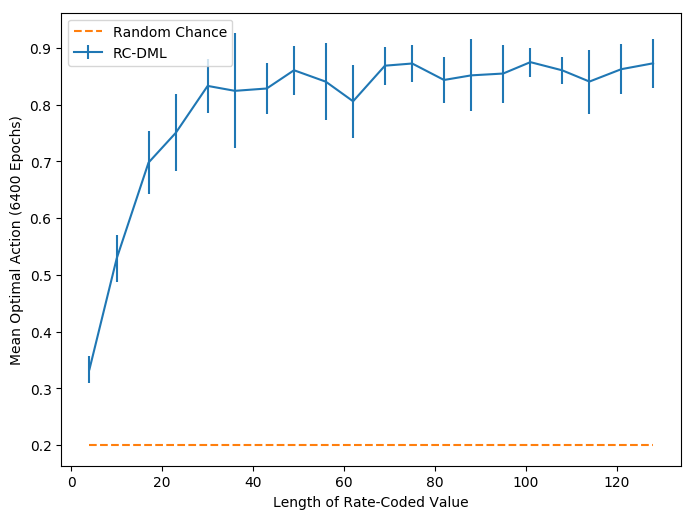

In [22]:
plt.figure(**plotargs)
plt.errorbar(l_epochs, avg(rc_performance['moa']), std(rc_performance['moa']), label="RC-DML")
plt.plot(l_epochs, 1.0 / n_actions * np.ones_like(l_epochs), "--", label="Random Chance")
plt.legend()
plt.xlabel("Length of Rate-Coded Value")
plt.ylabel("Mean Optimal Action (6400 Epochs)")

# CPU Comparison
We can do a comparison between the RC-DML and CPU approaches.

In [23]:
cpu_action, cpu_reward, cpu_estimate = egreedy(episodes, epsilon, 0.01, probabilities)

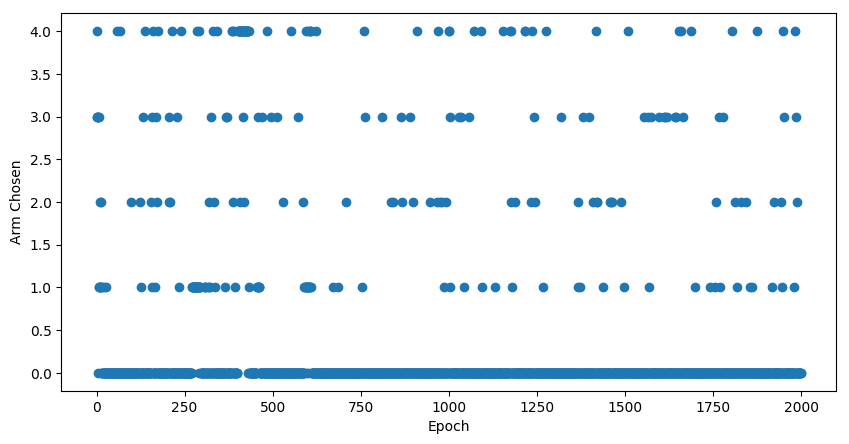

In [24]:
plot_choices(cpu_action, probabilities, figsize=(10,5), dpi=100)

Individual runs can vary widely due to initial conditions, so we make a comparison across multiple runs.

## Compare MOA and Rewards

In [25]:
epsilons = [0.01, 0.05, 0.10, 0.15]

In [26]:
n_trials = 5

In [27]:
trials = run_trials(probabilities, epsilons, l_epoch=l_epoch, trials=n_trials, episodes=6400)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:45735
INFO:DRV:      Host server up..............Done 0.29s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997463.8270833
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997463.8270833/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997463.8270833/initnetwork_0_0.c.o -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/

INFO:DRV:      Compiling Embedded snips....Done 0.66s
INFO:DRV:      Compiling MPDS Registers....Done 0.84ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997470.8630357/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 4.24ms
INFO:DRV:      Transferring probes.........Done 3.03ms
INFO:DRV:      Configuring registers.......Done 0.01s
INFO:DRV:      Transferring spikes.........Done 3.11ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.34s
INFO:DRV:      Processing timeseries.......Done 1.28ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 2.08ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.40s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:44687
INFO:DRV:      Host server up..............Done 0.28s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997484.2613802
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997484.2613802/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.78s
INFO:DRV:      Compiling MPDS Registers....Done 1.07ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997491.0199034/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 6.02ms
INFO:DRV:      Transferring probes.........Done 4.81ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 1.08ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.36s
INFO:DRV:      Processing timeseries.......Done 0.82ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 2.68ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.37s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:33751
INFO:DRV:      Host server up..............Done 0.27s
INFO:DRV:      Encoding axons/synapses.....Done 0.05s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997505.2465084
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997505.2465084/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.85s
INFO:DRV:      Compiling MPDS Registers....Done 2.60ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997512.0348468/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 4.56ms
INFO:DRV:      Transferring probes.........Done 9.76ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 4.10ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.34s
INFO:DRV:      Processing timeseries.......Done 0.79ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 0.80ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.39s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:37167
INFO:DRV:      Host server up..............Done 0.26s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997526.28266
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997526.28266/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/dr

INFO:DRV:      Compiling Embedded snips....Done 0.75s
INFO:DRV:      Compiling MPDS Registers....Done 3.65ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997533.0781374/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.20ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 4.03ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 1.06ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.32s
INFO:DRV:      Processing timeseries.......Done 1.13ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 1.12ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.37s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:44805
INFO:DRV:      Host server up..............Done 0.32s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997546.6150553
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997546.6150553/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.71s
INFO:DRV:      Compiling MPDS Registers....Done 2.95ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997553.4479754/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 7.70ms
INFO:DRV:      Transferring probes.........Done 3.23ms
INFO:DRV:      Configuring registers.......Done 0.04s
INFO:DRV:      Transferring spikes.........Done 0.82ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.33s
INFO:DRV:      Processing timeseries.......Done 1.28ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 0.85ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.41s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:37951
INFO:DRV:      Host server up..............Done 0.28s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997566.9984188
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997566.9984188/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.83s
INFO:DRV:      Compiling MPDS Registers....Done 0.87ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997573.8230555/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 2.31ms
INFO:DRV:      Transferring probes.........Done 4.66ms
INFO:DRV:      Configuring registers.......Done 0.01s
INFO:DRV:      Transferring spikes.........Done 1.11ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.33s
INFO:DRV:      Processing timeseries.......Done 1.27ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 1.18ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.37s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:39019
INFO:DRV:      Host server up..............Done 0.32s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997587.4311519
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997587.4311519/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.79s
INFO:DRV:      Compiling MPDS Registers....Done 1.19ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607997594.414557/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 1.46ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 6.02ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 1.14ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.33s
INFO:DRV:      Processing timeseries.......Done 3.09ms
INFO:DRV:  Executor: 819200 timeste

Text(0,0.5,'Average Proportion (6400 Epochs)')

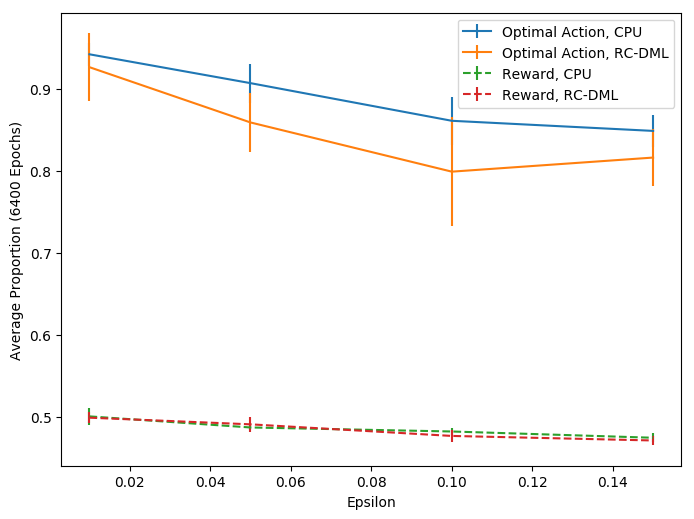

In [28]:
plt.figure(**plotargs)
plt.errorbar(epsilons, avg(trials['cpu_moa']), std(trials['cpu_moa']), label="Optimal Action, CPU")
plt.errorbar(epsilons, avg(trials['loihi_moa']), std(trials['loihi_moa']), label="Optimal Action, RC-DML")
plt.errorbar(epsilons, avg(trials['cpu_avgrwd']), std(trials['cpu_avgrwd']), linestyle="--", label="Reward, CPU")
plt.errorbar(epsilons, avg(trials['loihi_avgrwd']), std(trials['loihi_avgrwd']), linestyle="--", label="Reward, RC-DML")
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Average Proportion (6400 Epochs)")

In [29]:
loihi_choices = np.hstack([trials["loihi_results"][i][0] for i in range(5,10)])
cpu_choices = np.vstack([trials["cpu_results"][i][0] for i in range(5,10)]).transpose()

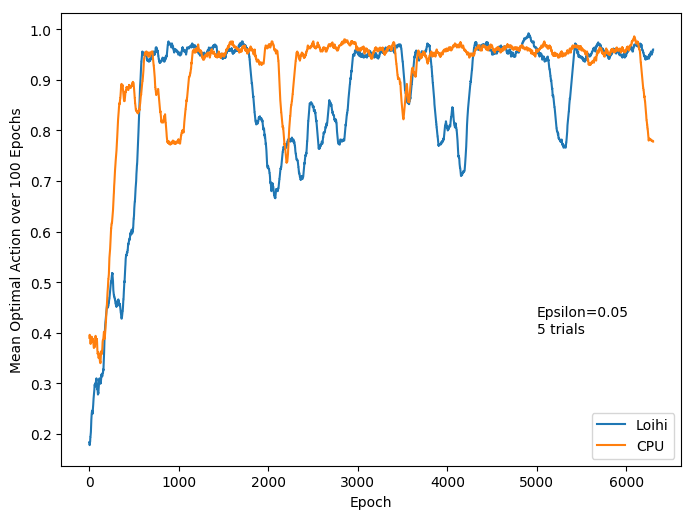

In [30]:
plt.figure(**plotargs)
plt.plot(np.convolve(np.sum(loihi_choices == optimal_arm, axis=1)/n_trials, np.ones(100), mode='valid')/100, label="Loihi")
plt.plot(np.convolve(np.sum(cpu_choices == optimal_arm, axis=1)/n_trials, np.ones(100), mode='valid')/100, label="CPU")
plt.xlabel("Epoch")
plt.ylabel("Mean Optimal Action over 100 Epochs")
plt.text(5000, 0.4, "Epsilon=0.05\n5 trials")
plt.legend()